<a href="https://colab.research.google.com/github/Rosvvald/TDA-Bourbaki/blob/main/Bourbaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Homología persistente aplicada a MNIST usando Dionysus**

El día de hoy aplicaremos la teoría vista las sesiones anteriores a un problema de clasificación de imágenes (preprocesamiento en realidad). Usaremos la biblioteca especializada Dionysus, la cual tenemos que instalar primero

In [ ]:
pip install --verbose dionysus

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


También importamos algunas bibliotecas útiles para el problema


In [ ]:
import dionysus as d
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
from sklearn import datasets

In [ ]:
mkdir "data"


In [ ]:
cd "data"

/content/data/data


Descarcaremos la base de datos MNIST del sitio *OpenML*, y la guardaremos en el directorio creado en las celdas anteriores.

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' prepare_data.py: Saves n_samples images of digits to numpy array.'''

#from __future__ import print_function # if you are using Python 2
import numpy as np
from sklearn.datasets import fetch_openml
import sys

n_samples = 10000
if len(sys.argv) == 2:
    print('Setting n_samples to: %i' % (n_samples))
    n_samples = int(sys.argv[1])

# load data from https://www.openml.org/d/554
print('Loading digits...')
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

np.save('../data/' + 'X_' + str(n_samples) + '.npy', X[:n_samples])
np.save('../data/' + 'y_' + str(n_samples) + '.npy', y[:n_samples])

Loading digits...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hacemos la partición

In [ ]:
data_X = np.load('../data/X_' + str(n_samples) + '.npy', allow_pickle=True)
data_y = np.load('../data/y_'  + str(n_samples) + '.npy', allow_pickle=True)


Pequeño análisis exploratorio

In [ ]:
print(data_X.shape)
print(data_y.shape)
print(data_X[0].shape)

(10000, 784)
(10000,)
(784,)


A continuación se presentan las funciones usadas para extraer los datos apropiados para los algoritmos de Dionysus

In [ ]:
# Obtiene una imagen de la base de datos, indizada con el entero 'n'

def get_image(n, plot = False):
  img = data_X[n]
  img = img.reshape((28,28))
  if plot:
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.show()
  return img

In [ ]:
# Obtiene la imagen en binario de la imagen original

def get_binary(img, plot = False):
  bi = img != 0
  if plot:
    plt.imshow(bi, cmap=plt.cm.gray_r)
    plt.show()
  return bi

In [ ]:
# Se obtiene el esqueleto de la imagen binaria usando el algoritmo de Zhang - Suen

def get_sk(bin_img, plot = False):
  skeleton = skeletonize(bin_img)
  if plot:
    plt.imshow(skeleton, cmap=plt.cm.gray_r)
    plt.show()
  return skeleton


In [ ]:
# Función que regresa la matriz de adyacencia, dada un esqueleto

def construct_graph(image):
    graph = {}
    vertices = []
    rows, cols = len(image), len(image)
    img = image.T

    # Añadimos vértices a la gráfica
    for i in range(rows):
        for j in range(cols):
            if img[i][j] == 1:
                vertex = (i, j)
                graph[vertex] = []
                vertices.append(vertex)

    # Añadimos aristas entre vértices adyacentes
    for vertex in graph.keys():
        i, j = vertex
        neighbors = get_neighbors(i, j, rows, cols)
        for neighbor in neighbors:
            if neighbor in graph:
                graph[vertex].append(neighbor)
    #print(graph)

    # Eliminamos los ciclos de dimensión 3 posiblemente creados
    remove_cycles_of_length_3(graph)

    # Construimos la matriz de adyacencia
    adjacency_matrix = np.zeros((len(vertices), len(vertices)), dtype=int)
    for i, vertex in enumerate(vertices):
        neighbors = graph[vertex]
        for neighbor in neighbors:
            j = vertices.index(neighbor)
            adjacency_matrix[i, j] = 1

    G = nx.from_numpy_array(adjacency_matrix)
    return G

def get_neighbors(i, j, rows, cols):
    neighbors = []
    directions = [(1,0), (1, 1), (0, 1), (-1, 1), (-1,0), (-1,-1), (0,-1), (1,-1)]

    for direction in directions:
        ni, nj = i + direction[0], j + direction[1]
        if 0 <= ni < rows and 0 <= nj < cols:
            neighbors.append((ni, nj))

    return neighbors

def remove_cycles_of_length_3(graph):
    for vertex in graph.keys():
        if len(graph[vertex]) == 2:
            neighbors = graph[vertex]
            if neighbors[0] in graph[neighbors[1]]:
                graph[neighbors[1]].remove(vertex)
                graph[vertex].remove(neighbors[1])

# **Dionysus**

Dionysus es una biblioteca que nos permite realizar cálculos de homología persistente básicos usando una sintaxis muy sencilla.

En primer lugar, podemos crear simplices con la función `Simplex`, e indicando el conjunto de vértices que lo conforman

In [ ]:
s = d.Simplex([0,1,2])
print(type(s))
print(s)

<class 'dionysus._dionysus.Simplex'>
<0,1,2> 0


Podemos incluir información en cada simplejo, el valor por default es 0.

Podemos crear filtraciones usando la función `Filtration`. Note que, en nuestro caso, podemos realizar la filtración incluyendo un simplejo a la vez

In [ ]:
## Construcción de la filtración por simplejos a partir de la gráfica de la imagen

def simp_fil(G):
  import time
  NV = G.nodes()
  EV = G.edges()
  simplices = []
  number_of = {}

  tic = time.time()
  for node in NV:
    clock = (time.time() - tic) * 1000
    simplices.append(([node], clock))
    number_of[node] = node

  for edge in EV:
    clock = (time.time() - tic) * 1000
    simplices.append((edge, clock))

  f = d.Filtration()
  for simplex, time in simplices:
    f.append(d.Simplex(simplex, time))

  f.sort()

  return f


Podemos extraer la homología persistente de una filtración de un espacio X, al llamar a la función `homology_persistence()`, la cual acepta una filtración y regresa la homología. Sin embargo, podemos extraer los códigos de barra mediante la función `d.init_diagrams()`, que acepta un objeto de homología y su filtración

In [ ]:
def betti_barcodes(f):
  p_hom = d.homology_persistence(f)
  dgms = d.init_diagrams(p_hom, f)

  barcodes = []
  for i, dgm in enumerate(dgms):
    for pt in dgm:
      barcodes.append([i, (pt.birth, pt.death)])

  return barcodes

In [ ]:
def extract_features(intervals):
    ''' Extracts 4 features:
        	sum_i { x_i * (y_i - x_i) }
        	sum_i { (y_max - y_i) * (y_i - x_i) }
        	sum_i { x_i^2 * (y_i - x_i)^4 }
        	sum_i { (y_max - y_i)^2 * (y_i - x_i)^4 }
    From the barcode intervals:
        (x1, y1), (x2, y2), ..., (x_n, y_n);
    Args:
        intervals::list
            Betti barcode intervals, for example: [[3.0, inf], [5.0, inf]]
    Returns:
        features::list
            The 4 computed features.
    '''
    xs = []
    ys = []
    for interval in intervals:
        x = interval[1][0]
        y = interval[1][1]
        if str(y) == 'inf': # replace the inf with image_size
            y = img_size
        xs.append(x)
        ys.append(y)

    f1, f2, f3, f4 = 0., 0., 0., 0.
    for i in range(len(xs)):
        f1 += xs[i] * (ys[i] - xs[i])
        f2 += (max(ys) - ys[i]) * (ys[i] - xs[i])
        f3 += math.pow(xs[i], 2) * math.pow(ys[i] - xs[i], 4)
        f4 += math.pow(max(ys) - ys[i], 2) * math.pow(ys[i] - xs[i], 4)

    return [f1, f2, f3, f4]


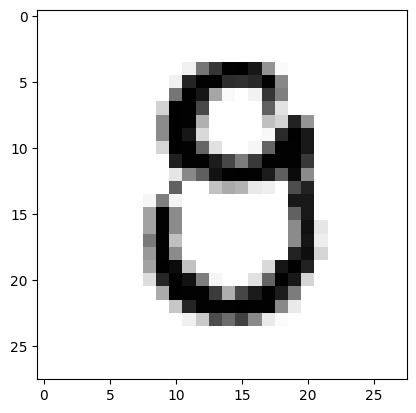

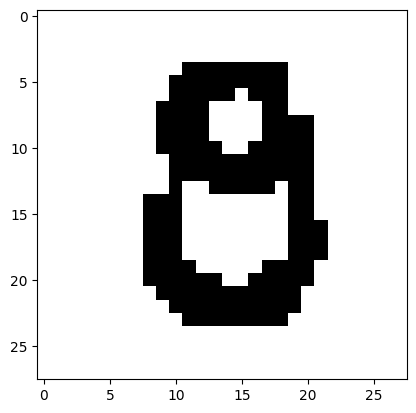

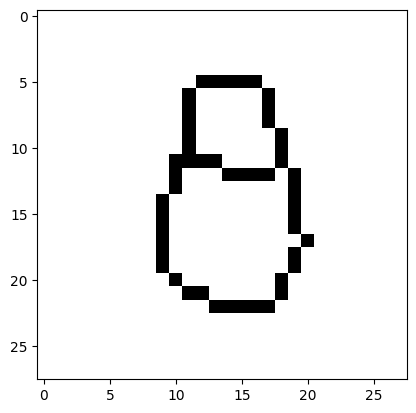

Dimensión: 0, intervalo: (0.00286102294921875, inf)
Dimensión: 0, intervalo: (0.0050067901611328125, 0.04839897155761719)
Dimensión: 0, intervalo: (0.006198883056640625, 0.05125999450683594)
Dimensión: 0, intervalo: (0.00667572021484375, 0.05316734313964844)
Dimensión: 0, intervalo: (0.007152557373046875, 0.05459785461425781)
Dimensión: 0, intervalo: (0.007867813110351562, 0.05555152893066406)
Dimensión: 0, intervalo: (0.009298324584960938, 0.061511993408203125)
Dimensión: 0, intervalo: (0.009775161743164062, 0.058650970458984375)
Dimensión: 0, intervalo: (0.01049041748046875, 0.049114227294921875)
Dimensión: 0, intervalo: (0.011444091796875, 0.05698204040527344)
Dimensión: 0, intervalo: (0.012159347534179688, 0.07104873657226562)
Dimensión: 0, intervalo: (0.013113021850585938, 0.06532669067382812)
Dimensión: 0, intervalo: (0.013828277587890625, 0.06842613220214844)
Dimensión: 0, intervalo: (0.01430511474609375, 0.06985664367675781)
Dimensión: 0, intervalo: (0.015020370483398438, 0.059

In [ ]:
example = get_image(80, plot = True)
imagen = get_binary(example, plot = True)
imagen = get_sk(imagen, plot = True)
G = construct_graph(imagen)
f = simp_fil(G)
betti = betti_barcodes(f)
#print(extract_features(betti))

for interval in betti:
  print("Dimensión:", str(interval[0]) + ",", "intervalo:", interval[1])


In [ ]:
def extract_all_features(n):
    ''' Extracts features of nth image, all together:
            4 sweeps * (2 barcodes * 4 features) = 32 features
        Args:
            n::int
                The number of the handwritten digit image, for example:
                    n = 17 for image of number 8.
        Returns:
            all_features::list
                The 32 computed features.
    '''
    image = get_image(n)
    binary_image = get_binary(image)
    skeleton = get_sk(binary_image)

    all_features = []
    G_d = construct_graph(skeleton)
    f_d = simp_fil(G_d)
    betti_d = betti_barcodes(f_d)
    f0 = extract_features(betti_d)
    G_u = construct_graph(skeleton.T)
    f_u = simp_fil(G_u)
    betti_u = betti_barcodes(f_u)
    f1 = extract_features(betti_u)

    #for sweep_direction in ['right', 'left', 'top', 'bottom']:
    #    points = get_points(skeleton, sweep_direction)
    #    point_list = PointList(points)
    #    emb_graph = point_list.get_emb_graph()
    #    simplices = get_simplices(emb_graph)
    #    intervals = get_betti_barcodes(simplices)

        f0 = extract_features(intervals[0])
        f1 = extract_features(intervals[1])
        features = f0 + f1
        all_features += features

    return all_features

def save_features_matrix(n_samples=1000):
    ''' Saves the feature matrix of shape (n_samples, n_features) to ../data
    directory.
    Args:
        n_samples::int
            Number of samples of handwritten digit images.
    '''
    df = np.zeros((n_samples, n_features))

    # extract all features of each image and save it to an array
    print('Extracting all features...')
    for n in range(n_samples):
        df[n] = extract_all_features(n)

    #print('Features extracted.')
    #np.save('../data/' + 'features_' + str(n_samples) + '.npy', df)